In [4]:
import matplotlib.pyplot as plt
from visualizer import print_result, display_stocks_graph
import pandas as pd
import yfinance as yf
import numpy as np
from get_optimal_stocks import *
from datetime import datetime

# Define start and end dates
start_date = (2018, 1, 1)
end_date = (2020, 1, 1)
start = datetime(*start_date)
end = datetime(*end_date)

Portfolio_total_value = 1000000  # This is in dollar



In [5]:
# Create an empty dictionary to store dataframes
stock_data = {}

# Define the stock symbols (Yahoo Finance uses different symbols compared to Quandl)
stock_symbols = ['AAPL', 'MSFT', 'AMZN']

# Fetch data from Yahoo Finance
for stock_symbol in stock_symbols:
    try:
        stock_df = yf.download(stock_symbol, start=start, end=end)
        # Process the stock data
        stock_df['Normed Return'] = stock_df['Adj Close'] / stock_df.iloc[0]['Adj Close']
        # Store the dataframe in the dictionary
        stock_data[stock_symbol] = stock_df
    except Exception as e:
        print(f"Error retrieving data for symbol: {stock_symbol}. Error message: {e}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



AAPL DataFrame Head:
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.615887  102223600   
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.608814  118071600   
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.797443   89738400   
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.261932   94640000   
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.108673   82271200   

            Normed Return  
Date                       
2018-01-02       1.000000  
2018-01-03       0.999826  
2018-01-04       1.004470  
2018-01-05       1.015906  
2018-01-08       1.012133  

MSFT DataFrame Head:
                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2018-01-02  86.129997  86.309998  85.5000

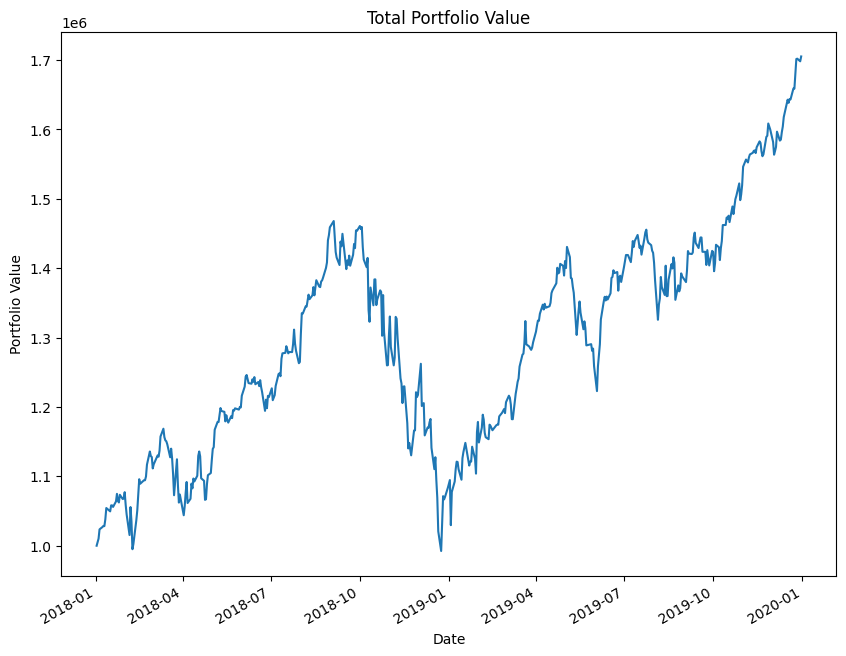

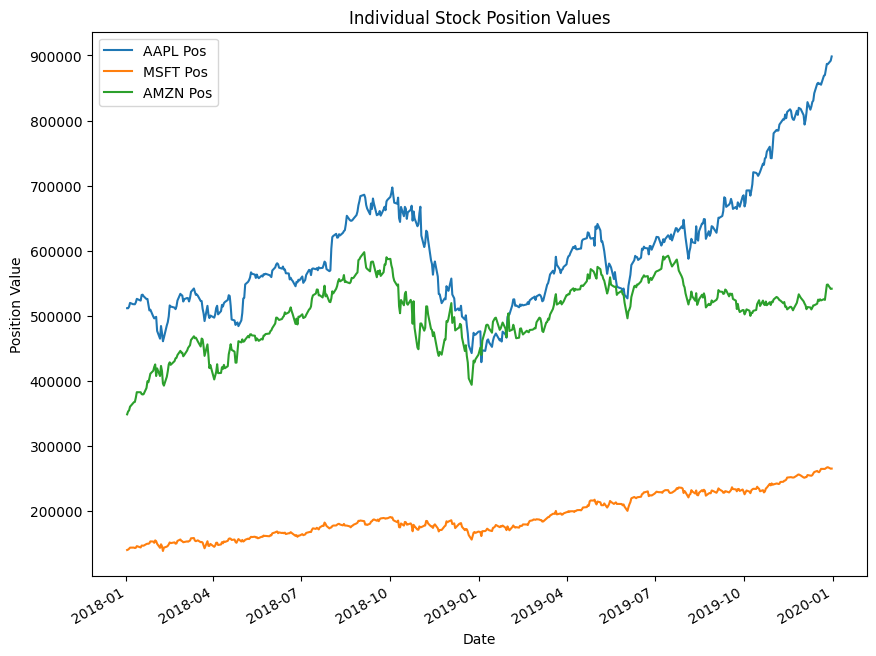

In [6]:
# Access and display dataframes (similar to the original loop)
for stock_name, stock_df in stock_data.items():
    print(f"\n{stock_name} DataFrame Head:")
    print(stock_df.head())

# Generate random allocations
allocations = np.random.rand(len(stock_symbols))
# Normalize allocations so they add up to 1
allocations /= allocations.sum()
print(allocations)

# Calculate and add position values to each dataframe
for stock_symbol, allocation in zip(stock_symbols, allocations):
    stock_df = stock_data[stock_symbol]
    stock_df['Allocation'] = stock_df['Normed Return'] * allocation
    stock_df['Position Values'] = stock_df['Allocation'] * Portfolio_total_value

# Display the head of the JPM dataframe with allocation and position values
print("\nJPM DataFrame with Allocation and Position Values Head:")
print(stock_data[stock_symbols[0]].head())

# Combine the position values into a single DataFrame and calculate the total position
portfolio_val = pd.concat([stock_data[symbol]['Position Values'] for symbol in stock_symbols], axis=1)
portfolio_val.columns = [f"{symbol} Pos" for symbol in stock_symbols]
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

# Display the head of the portfolio valuation DataFrame
print("\nPortfolio Valuation DataFrame Head:")
print(portfolio_val.head())

# Plot the total portfolio value
portfolio_val['Total Pos'].plot(figsize=(10, 8))
plt.title('Total Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

# Plot the individual stock position values
portfolio_val.drop('Total Pos', axis=1).plot(kind='line', figsize=(10, 8))
plt.title('Individual Stock Position Values')
plt.xlabel('Date')
plt.ylabel('Position Value')
plt.show()

portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)


In [7]:
# Calculate the cumulative return
cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)
print('Our cumulative return is {} percent!'.format(cum_ret))

# Calculate mean daily return and standard deviation
mean_daily_return = portfolio_val['Daily Return'].mean()
std_daily_return = portfolio_val['Daily Return'].std()

# Calculate Sharpe Ratio
SR = mean_daily_return / std_daily_return
ASR = (252**0.5) * SR
print('Annualized Sharpe Ratio:', ASR)

# Extract and combine the adjusted close prices into a single DataFrame for daily returns
close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}
stocks = pd.DataFrame(close_data)

# Calculate logarithmic returns
log_ret = np.log(stocks / stocks.shift(1))

# One iteration example
np.random.seed(101)
weights = np.random.random(len(stock_symbols))
weights /= np.sum(weights)

exp_ret = np.sum(log_ret.mean() * weights) * 252
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
SR = exp_ret / exp_vol


Our cumulative return is 70.51290520099036 percent!
Annualized Sharpe Ratio: 1.197597381287117


C:\Users\awadh\AppData\Local\Temp\ipykernel_12144\3492375205.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)


In [8]:
# Monte Carlo simulation
num_ports = 50000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
cvar_arr = np.zeros(num_ports)

for ind in range(num_ports):
    weights = np.random.random(len(stock_symbols))
    weights /= np.sum(weights)
    
    all_weights[ind, :] = weights
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
    
    # Calculate portfolio returns for CVaR
    portfolio_returns = log_ret.dot(weights)
    portfolio_returns = portfolio_returns.dropna()  # Drop NaN values
    
    # Calculate Value at Risk (VaR)
    VaR = np.percentile(portfolio_returns, 5)
    
    # Calculate CVaR
    cvar_arr[ind] = portfolio_returns[portfolio_returns <= VaR].mean()



C:\Users\awadh\AppData\Local\Temp\ipykernel_12144\1748860826.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1
C:\Users\awadh\AppData\Local\Temp\ipykernel_12144\1748860826.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0]) ** (1 / years) - 1


Optimal Weights: [0.17749091 0.82001169 0.0024974 ]
Expected Return: 31.37%
Expected Volatility: 23.60%
Sharpe Ratio: 1.33
CVaR: -3.56%
Annualized Return: 30.60%
CAGR: 30.60%
Annualized Volatility (Risk): 23.60%


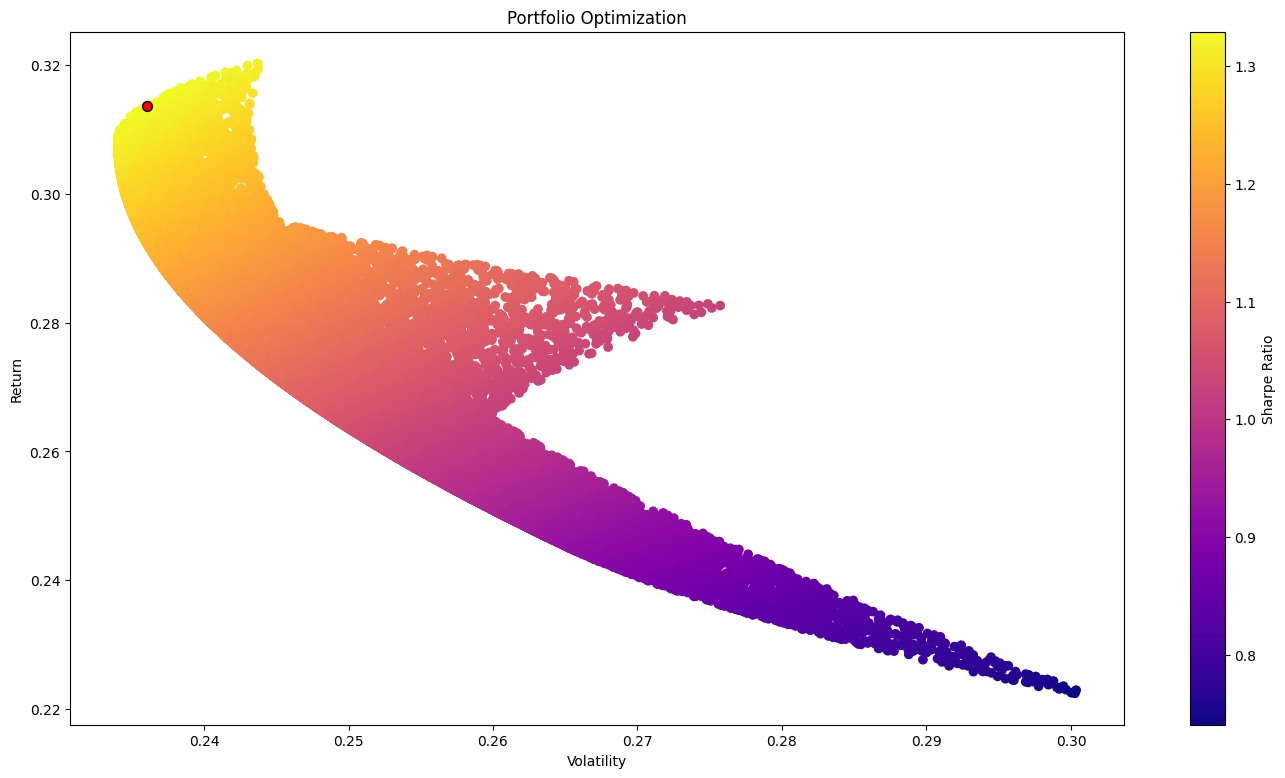

Values to be invested in each stock for portfolio of value 1000000 $
AAPL : $177490.90900988193
MSFT : $820011.6884212247
AMZN : $2497.402568893362


In [11]:
# Identify the portfolio with the highest Sharpe Ratio
max_sr_idx = sharpe_arr.argmax()
optimal_weights = all_weights[max_sr_idx, :]


# Calculate additional metrics
years = (end - start).days / 365.25
total_return = portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1
annualized_return = (1 + total_return) ** (1 / years) - 1
annualized_volatility = vol_arr[max_sr_idx]
cagr = (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0]) ** (1 / years) - 1

# Print results
print(f'Optimal Weights: {optimal_weights}')
print(f'Expected Return: {ret_arr[max_sr_idx] * 100:.2f}%')
print(f'Expected Volatility: {vol_arr[max_sr_idx] * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_arr[max_sr_idx]:.2f}')
print(f'CVaR: {cvar_arr[max_sr_idx] * 100:.2f}%')
print(f'Annualized Return: {annualized_return * 100:.2f}%')
print(f'CAGR: {cagr * 100:.2f}%')
print(f'Annualized Volatility (Risk): {annualized_volatility * 100:.2f}%')

# Plotting the results
plt.figure(figsize=(17, 9))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol_arr[max_sr_idx], ret_arr[max_sr_idx], c='red', s=50, edgecolors='black')
plt.title('Portfolio Optimization')
plt.show()

# Output the portfolio weights
print(f'Values to be invested in each stock for portfolio of value {Portfolio_total_value} $')
for i, symbol in enumerate(stock_symbols):
    print(f'{symbol} : ${optimal_weights[i] * Portfolio_total_value}')